In [261]:
import pandas as pd
import os
from os.path import join
import pylab as plt

In [263]:
# Path the data directory
outputs_dir = join(os.getcwd(), '..', 'outputs', 'test_senario')

In [265]:
gen = pd.read_csv(join(outputs_dir, 'generation.csv'))

<Axes: >

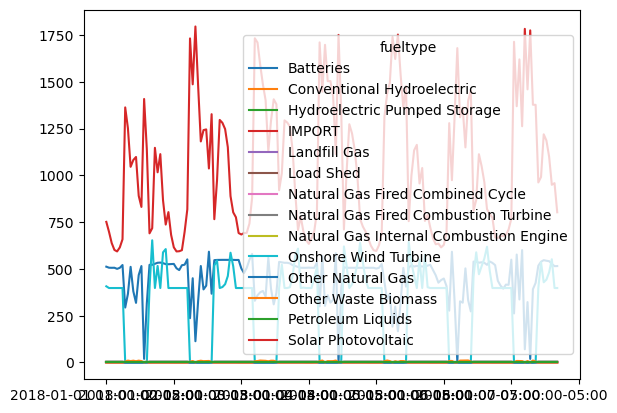

In [267]:
gen.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum().T.plot()

In [269]:
grouped = gen.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum()
grouped

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-07 15:00:00-05:00,2018-01-07 16:00:00-05:00,2018-01-07 17:00:00-05:00,2018-01-07 18:00:00-05:00,2018-01-07 19:00:00-05:00,2018-01-07 20:00:00-05:00,2018-01-07 21:00:00-05:00,2018-01-07 22:00:00-05:00,2018-01-07 23:00:00-05:00,2018-01-08 00:00:00-05:00
fueltype,,,,,,,,,,,,,,,,,,,,,
Batteries,511.818000,506.2590,505.800,506.1060,500.1666,505.8000,520.692988,293.539582,366.206014,510.964033,...,391.590713,425.275657,517.2240,538.185000,546.70200,543.489000,541.296000,526.965000,514.5720,515.0820
Conventional Hydroelectric,1.500000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.5000,1.500000,1.50000,1.500000,1.500000,1.500000,1.5000,1.5000
Hydroelectric Pumped Storage,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.0000
IMPORT,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.010861,0.482518,0.000000,0.769547,...,0.000000,0.414252,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.0000
Landfill Gas,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.0000
Load Shed,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.0000
Natural Gas Fired Combined Cycle,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.008533,0.447997,0.699729,0.706840,...,0.718218,0.381153,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.0000
Natural Gas Fired Combustion Turbine,4.800000,4.8000,4.800,4.8000,4.8000,4.8000,4.800000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.8000,4.800000,4.80000,4.800000,4.800000,4.800000,4.8000,4.8000
Natural Gas Internal Combustion Engine,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.0000


In [272]:
prices = pd.read_csv(join(outputs_dir, 'prices.csv'))

In [274]:
prices

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-07 15:00:00-05:00,2018-01-07 16:00:00-05:00,2018-01-07 17:00:00-05:00,2018-01-07 18:00:00-05:00,2018-01-07 19:00:00-05:00,2018-01-07 20:00:00-05:00,2018-01-07 21:00:00-05:00,2018-01-07 22:00:00-05:00,2018-01-07 23:00:00-05:00,2018-01-08 00:00:00-05:00
0,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,0.0,0.0,0.0,...,0.0,8.863328,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
1,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,0.0,0.0,0.0,...,0.0,8.863328,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
2,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,0.0,0.0,0.0,...,0.0,8.863328,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
3,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,0.0,0.0,0.0,...,0.0,8.863328,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
4,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,0.0,0.0,0.0,...,0.0,8.863436,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,0.0,0.0,0.0,...,0.0,8.863323,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
485,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,0.0,0.0,0.0,...,0.0,8.863356,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
486,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,0.0,0.0,0.0,...,0.0,8.863420,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
487,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,14.548737,0.0,0.0,0.0,...,0.0,8.864047,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472


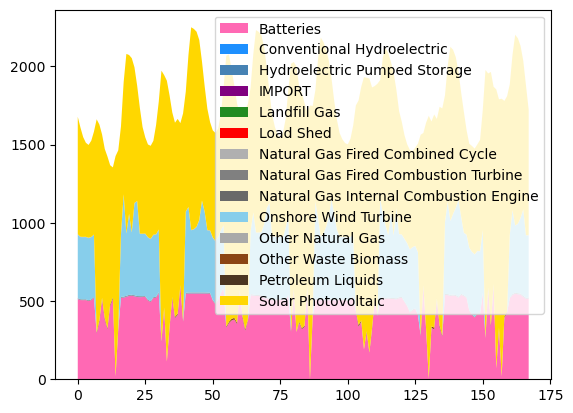

In [276]:
y = grouped.to_numpy()

fig, ax = plt.subplots()
plt.stackplot(range(len(y.T)), y, labels=grouped.index, colors=[i[1] for i in generator_colors]);
plt.legend()

In [249]:
generator_colors = [
    ("Solar Photovoltaic", "#FFD700"),
    ("Onshore Wind Turbine", "#87CEEB"),
    ("Conventional Hydroelectric", "#1E90FF"),
    ("Hydroelectric Pumped Storage", "#4682B4"),
    ("Natural Gas Fired Combined Cycle", "#B0B0B0"),
    ("Natural Gas Fired Combustion Turbine", "#808080"),
    ("Natural Gas Internal Combustion Engine", "#696969"),
    ("Other Natural Gas", "#A9A9A9"),
    ("Petroleum Liquids", "#4B3621"),
    ("Landfill Gas", "#228B22"),
    ("Other Waste Biomass", "#8B4513"),
    ("Batteries", "#FF69B4"),
    ("IMPORT", "#800080"),
    ("Load Shed", "#FF0000")
]
generator_colors.sort()